# Import necessary libraries

In [2]:
import numpy as np
import os
import glob
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import pickle

from keras.utils import to_categorical, plot_model
from keras.layers import Dense, Input, Conv2D, Flatten, MaxPool2D, Activation
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras import backend as K


# Setting up variables

In [3]:
FIG_WIDTH=20 
ROW_HEIGHT=3 
RESIZE_DIM=28 

# Setting up directories for training and testing datas

In [4]:
data_dir=os.path.join('..','/home/hasib/Hasib/Others/NumtaDB_with_aug')
paths_train_a=glob.glob(os.path.join(data_dir,'training-a','*.png'))
paths_train_b=glob.glob(os.path.join(data_dir,'training-b','*.png'))
paths_train_e=glob.glob(os.path.join(data_dir,'training-e','*.png'))
paths_train_c=glob.glob(os.path.join(data_dir,'training-c','*.png'))
paths_train_d=glob.glob(os.path.join(data_dir,'training-d','*.png'))
paths_train_all=paths_train_a+paths_train_b+paths_train_c+paths_train_d+paths_train_e

paths_test_a=glob.glob(os.path.join(data_dir,'testing-a','*.png'))
paths_test_b=glob.glob(os.path.join(data_dir,'testing-b','*.png'))
paths_test_e=glob.glob(os.path.join(data_dir,'testing-e','*.png'))
paths_test_c=glob.glob(os.path.join(data_dir,'testing-c','*.png'))
paths_test_d=glob.glob(os.path.join(data_dir,'testing-d','*.png'))
paths_test_f=glob.glob(os.path.join(data_dir,'testing-f','*.png'))+glob.glob(os.path.join(data_dir,'testing-f','*.JPG'))
paths_test_auga=glob.glob(os.path.join(data_dir,'testing-auga','*.png'))
paths_test_augc=glob.glob(os.path.join(data_dir,'testing-augc','*.png'))
paths_test_all=paths_test_a+paths_test_b+paths_test_c+paths_test_d+paths_test_e+paths_test_f+paths_test_auga+paths_test_augc

path_label_train_a=os.path.join(data_dir,'training-a.csv')
path_label_train_b=os.path.join(data_dir,'training-b.csv')
path_label_train_e=os.path.join(data_dir,'training-e.csv')
path_label_train_c=os.path.join(data_dir,'training-c.csv')
path_label_train_d=os.path.join(data_dir,'training-d.csv')

# Useful functions 

In [5]:
def get_key(path):
    key=path.split(sep=os.sep)[-1]
    return key

def get_data(paths_img,path_label=None,resize_dim=None):
    X=[] 
    for i,path in enumerate(paths_img):
        img=cv2.imread(path,cv2.IMREAD_COLOR) 
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        if resize_dim is not None:
            img=cv2.resize(img,(resize_dim,resize_dim),interpolation=cv2.INTER_AREA) 
        X.append(img) 
      
        if i==len(paths_img)-1:
            end='\n'
        else: end='\r'
        print('processed {}/{}'.format(i+1,len(paths_img)),end=end)
        
    X=np.array(X) 
    if  path_label is None:
        return X
    else:
        df = pd.read_csv(path_label) 
        df=df.set_index('filename') 
        y_label=[df.loc[get_key(path)]['digit'] for path in  paths_img] 
        y=to_categorical(y_label,10) 
        return X, y

def imshow_group(X,y=None,y_pred=None,n_per_row=10):
    n_sample=len(X)
    img_dim=X.shape[1]
    j=np.ceil(n_sample/n_per_row)
    fig=plt.figure(figsize=(FIG_WIDTH,ROW_HEIGHT*j))
    for i,img in enumerate(X):
        plt.subplot(j,n_per_row,i+1)
        plt.imshow(img)
        if y is not None:
                plt.title('true label: {}'.format(np.argmax(y[i])))
        if y_pred is not None:
            top_n=3 # top 3 predictions with highest probabilities
            ind_sorted=np.argsort(y_pred[i])[::-1]
            h=img_dim+4
            for k in range(top_n):
                string='pred: {} ({:.0f}%)\n'.format(ind_sorted[k],y_pred[i,ind_sorted[k]]*100)
                plt.text(img_dim/2, h, string, horizontalalignment='center',verticalalignment='center')
                h+=4
        plt.axis('off')
    plt.show()
def create_submission(predictions,keys,path):
    result = pd.DataFrame(
        predictions,
        columns=['label'],
        index=keys
        )
    result.index.name='key'
    result.to_csv(path, index=True)

# Pre-process training & testing data

In [10]:
X_train_a,y_train_a=get_data(paths_train_a,path_label_train_a,resize_dim=RESIZE_DIM)
X_train_b,y_train_b=get_data(paths_train_b,path_label_train_b,resize_dim=RESIZE_DIM)
X_train_c,y_train_c=get_data(paths_train_c,path_label_train_c,resize_dim=RESIZE_DIM)
X_train_d,y_train_d=get_data(paths_train_d,path_label_train_d,resize_dim=RESIZE_DIM)
X_train_e,y_train_e=get_data(paths_train_e,path_label_train_e,resize_dim=RESIZE_DIM)

processed 19702/19702
processed 359/359
processed 24298/24298
processed 10908/10908
processed 16778/16778


In [11]:
X_train_all=np.concatenate((X_train_a,X_train_b,X_train_c,X_train_d,X_train_e),axis=0)
y_train_all=np.concatenate((y_train_a,y_train_b,y_train_c,y_train_d,y_train_e),axis=0)
X_train_all.shape, y_train_all.shape

((72045, 28, 28, 3), (72045, 10))

In [12]:
X_test_a=get_data(paths_test_a,resize_dim=RESIZE_DIM)
X_test_b=get_data(paths_test_b,resize_dim=RESIZE_DIM)
X_test_c=get_data(paths_test_c,resize_dim=RESIZE_DIM)
X_test_d=get_data(paths_test_d,resize_dim=RESIZE_DIM)
X_test_e=get_data(paths_test_e,resize_dim=RESIZE_DIM)
X_test_f=get_data(paths_test_f,resize_dim=RESIZE_DIM)
X_test_auga=get_data(paths_test_auga,resize_dim=RESIZE_DIM)
X_test_augc=get_data(paths_test_augc,resize_dim=RESIZE_DIM)

processed 3489/3489
processed 69/69
processed 4381/4381
processed 1948/1948
processed 2970/2970
processed 495/495
processed 2168/2168
processed 2106/2106


In [13]:
X_test_all=np.concatenate((X_test_a,X_test_b,X_test_c,X_test_d,X_test_e,X_test_f,X_test_auga,X_test_augc))

In [14]:
X_test_all.shape

(17626, 28, 28, 3)

# Split between training and validation data

Next, we are going to randomly choose 80% of the training data and use it to train our neural network. The remaining 20% images are going to be our validation data.

In [15]:
indices=list(range(len(X_train_all)))
np.random.seed(42)
np.random.shuffle(indices)

ind=int(len(indices)*0.80)

# train data
X_train=X_train_all[indices[:ind]] 
y_train=y_train_all[indices[:ind]]
# validation data
X_val=X_train_all[indices[-(len(indices)-ind):]] 
y_val=y_train_all[indices[-(len(indices)-ind):]]


# Model based on LeNet Architecture

Made modification the the model

In [26]:
def get_model():
    input_layer=Input(shape=(RESIZE_DIM,RESIZE_DIM,3))
    
    x=Conv2D(filters=8,kernel_size=(5,5),padding='valid', activation='relu')(input_layer)
    x=MaxPool2D(pool_size=(2,2),strides=2,padding='valid')(x)
    
    x=Conv2D(filters=16,kernel_size=(3,3),padding='valid', activation='relu')(x)
    x=MaxPool2D(pool_size=(2,2),strides=2,padding='valid')(x)
    
    x=Conv2D(filters=32,kernel_size=(3,3),padding='valid', activation='relu')(x)
    x=MaxPool2D(pool_size=(2,2),strides=2,padding='valid')(x)
    
    #new
    x=Conv2D(filters=64,kernel_size=(3,3),padding='same', activation='relu')(x)
    x=MaxPool2D(pool_size=(2,2),strides=2,padding='same')(x)
    
    x=Conv2D(filters=64,kernel_size=(3,3),padding='same', activation='relu')(x)
    x=MaxPool2D(pool_size=(2,2),strides=2,padding='same')(x)
    
    x=Conv2D(filters=64,kernel_size=(3,3),padding='same', activation='relu')(x)
    x=MaxPool2D(pool_size=(2,2),strides=2,padding='same')(x)
    
    x=Conv2D(filters=64,kernel_size=(3,3),padding='same', activation='relu')(x)
    x=MaxPool2D(pool_size=(2,2),strides=2,padding='same')(x)
    
    x=Flatten()(x)
    
    x=Dense(units=64)(x)
    x=Dense(units=10)(x) 
    
    output_layer=Activation('softmax')(x)
    model=Model(inputs=input_layer,outputs=output_layer)
    model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')
    return model
model=get_model()
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 3)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 8)         608       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 8)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 10, 10, 16)        1168      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 3, 3, 32)          4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 1, 1, 32)          0         
__________

# Train, save the model and Validate 

In [27]:
path_model='model_first_keras.h5' # save model at this location after each epoch
K.tensorflow_backend.clear_session() 
model=get_model() 
K.set_value(model.optimizer.lr,1e-3) 

h=model.fit(x=X_train,     
            y=y_train, 
            batch_size=64, 
            epochs=5, 
            verbose=1, 
            validation_data=(X_val,y_val),
            shuffle=True,
            callbacks=[
                ModelCheckpoint(filepath=path_model),
            ]
            )


Train on 57636 samples, validate on 14409 samples
Epoch 1/5
57636/57636 [==============================] - 50s 863us/step - loss: 1.1488 - acc: 0.5762 - val_loss: 0.6534 - val_acc: 0.7794
Epoch 2/5
57636/57636 [==============================] - 47s 817us/step - loss: 0.5406 - acc: 0.8153 - val_loss: 0.4294 - val_acc: 0.8559
Epoch 3/5
57636/57636 [==============================] - 46s 799us/step - loss: 0.4140 - acc: 0.8620 - val_loss: 0.3808 - val_acc: 0.8736
Epoch 4/5
57636/57636 [==============================] - 46s 794us/step - loss: 0.3616 - acc: 0.8809 - val_loss: 0.3607 - val_acc: 0.8819
Epoch 5/5
57636/57636 [==============================] - 46s 800us/step - loss: 0.3241 - acc: 0.8938 - val_loss: 0.3074 - val_acc: 0.8994


# Make predictions on the testing datas

In [30]:
predictions_prob=model.predict(X_test_all) 

Look at random prediction from the testing data

In [29]:
n_sample=20
np.random.seed(42)
ind=np.random.randint(0,len(X_test_all), size=n_sample)

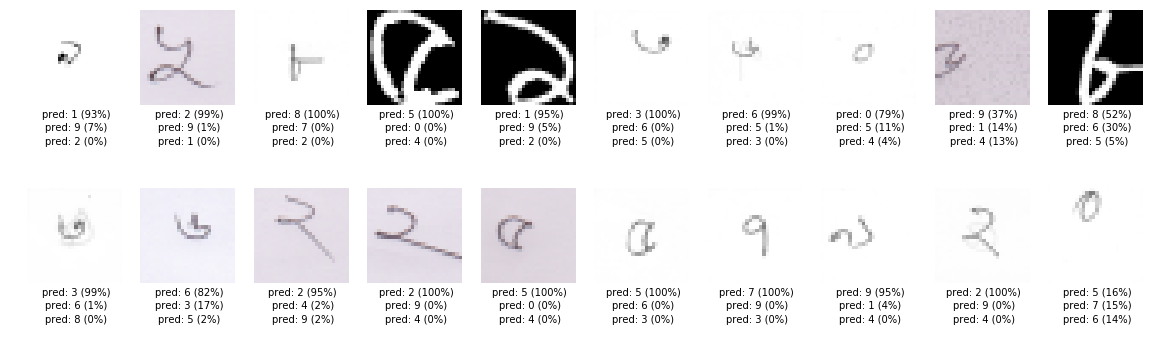

In [31]:
imshow_group(X=X_test_all[ind],y=None,y_pred=predictions_prob[ind])

# Make a CSV file from the testng data generated 

In [32]:
labels=[np.argmax(pred) for pred in predictions_prob]

In [33]:
keys=[get_key(path) for path in paths_test_all ]

In [34]:
create_submission(predictions=labels,keys=keys,path='hasib_first_keras.csv')